In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from operator import xor

In [3]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [4]:
n = 5
m = 20
d = 3

### Define Dataset

In [99]:
# x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
# y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)
# dataset = '3PTS'

In [100]:
x = array([[ 1.        , -0.77859717,  0.91411701],
       [ 1.        , -0.93180691,  0.78863155],
       [ 1.        ,  0.17577044, -0.91032515],
       [ 1.        ,  0.65264079,  0.85918343],
       [ 1.        ,  0.90145257, -0.833918  ]])
y = array([-1, -1,  1,  1, -1])
dataset = 'COLT_A'

In [101]:
# x = array([[ 1.        , -0.85980478,  0.83341569],
#        [ 1.        , -0.08936983,  0.65931124],
#        [ 1.        , -0.85677171, -0.75766464],
#        [ 1.        , -0.00356996, -0.07931816],
#        [ 1.        , -0.81647835, -0.71471585]])
# y = array([-1,  1,  1, -1,  1])
# dataset = 'COLT_B'

In [102]:
# x = array([[ 1.        ,  0.10789742, -0.85918415],
#        [ 1.        , -0.04298895, -0.00617151],
#        [ 1.        ,  0.70161108, -0.80821952],
#        [ 1.        ,  0.05411285,  0.88570957],
#        [ 1.        ,  0.9732608 ,  0.78365452]])
# y = array([ 1, -1, -1,  1,  1])
# dataset = 'COLT_C'

In [103]:
# def create_sample():
#     cluster_centers = [-0.8, 0, 0.8]
#     choice = np.random.choice(cluster_centers, size=2, replace=True)
    
#     y_sample = -1
#     if (choice[0] != -choice[1]) and not (choice[0] == 0.8 and choice[1] == 0):
#         y_sample = 1    
    
#     choice += np.random.normal(loc=0, scale=0.1, size=(2,))
#     x_sample = np.concatenate([np.ones((1, )), choice])

#     return x_sample.reshape(1, -1), y_sample

In [104]:
# samples = [create_sample() for _ in range(n)]
# x = np.concatenate([sample[0] for sample in samples])
# y = np.array([sample[1] for sample in samples]).reshape(-1,)
# dataset = 'COLT'

### Solve L1

In [105]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [106]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

RuntimeError: Minimization Failed.

In [ ]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [ ]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [ ]:
np.linalg.norm(w_tilde_norms_opt_L1, ord=1)

In [ ]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

In [ ]:
normalized_margins(w_opt_L1, a_opt_L1, x, y)

### Empirical Gradient Flow

In [107]:
def get_s_from_s_val(s_val):
    return [s_val] * m

In [19]:
def train_worker(alpha, s_val, m, d):
    w_0, a_0 = symmetric_init(alpha=alpha, s=get_s_from_s_val(s_val),  m=m, d=d, symmetric=True)
    
    results = {}
    results[s_val] = train(
        w_0=w_0,
        a_0=a_0,
        x=x,
        y=y,
        step_size=1e-6,
        n_epochs=50000000,
        eval_freq=1000)
    
    results[s_val].update({'w_0': w_0, 'a_0': a_0})
    return results

In [20]:
alpha = [100] * m 
s_vals = [0, 0.5, 0.95, -0.5, -0.95, 0.999, -0.999]

In [21]:
pool = mp.Pool(processes=len(s_vals))
pool_output = [pool.apply_async(train_worker, args=(alpha, s_val, m, d)) for s_val in s_vals]
results = {}
[results.update(p_out.get()) for p_out in pool_output]

100%|██████████| 50000000/50000000 [1:06:02<00:00, 12616.78it/s]


[None, None, None, None, None, None, None]

In [22]:
def downsample_results(res_dict, sample_freq=10, start_from=1000, excluded_keys=['w_0', 'a_0']):
    res_dict_downsampled = {}
    for k, v in res_dict.items():
        if not isinstance(v, dict):
            raise NotImplementedError('Expected nested results dict.')
        
        res_dict_downsampled[k] = {}
        for k_v, v_v in v.items():
            if k_v in excluded_keys:
                res_dict_downsampled[k][k_v] = v_v
            else:
                res_dict_downsampled[k][k_v] = v_v[:start_from] + v_v[start_from::sample_freq]
    return res_dict_downsampled

In [23]:
# downsample results
results_GD = downsample_results(results)

In [24]:
np.save(f'../results/linear__GD_{dataset}_alpha_{alpha[0]}_m_{m}.npy',  results_GD) 

In [93]:
# results_GD_restored = np.load('../results/GD_COLT_A_alpha_100_m_20.npy', allow_pickle=True)
# results_GD = results_GD_restored[()]

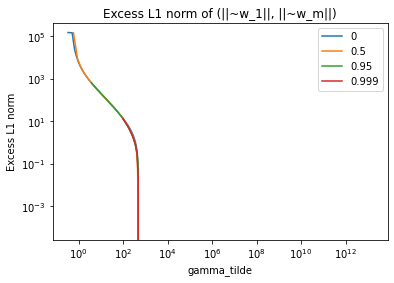

In [94]:
for k, res in results_GD.items():
    if k not in [0, 0.5, 0.95, 0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res['w_tilde_norms']],
        '')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, 0.5, 0.95, 0.999]);

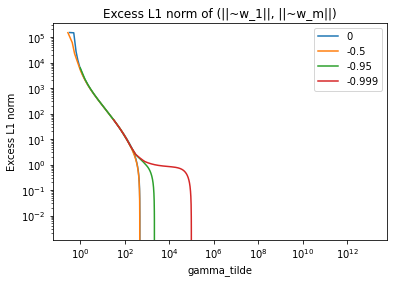

In [95]:
for k, res in results_GD.items():
    if k not in [0, -0.5, -0.95, -0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res['w_tilde_norms']],
        '')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, -0.5, -0.95, -0.999]);

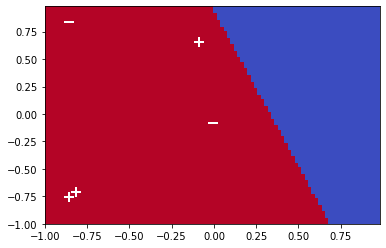

In [96]:
plot_classifier(results_GD[0]['w'][-1], results_GD[0]['a'][-1], x, y)

### S.V stability

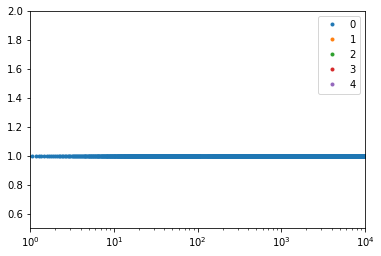

In [91]:
res_GD = results_GD[0.5]

for idx in range(len(x)):
    plot(
        [t for t in res_GD['training_loss']],
        [normalized_margins(w, a, x, y)[idx] for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '.')
ylim([0.5, 2])
xlim([1, alpha[0]**2])
xscale('log')
legend(list(range(len(x))))

### Estimate Q Minimization

In [30]:
def run_Q_minimization(alpha, s, w_0, a_0):
    mu_Q = []
    w_array_Q = []
    a_array_Q = []

    for mu_val in tqdm([1e-4, 1e-3, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50, 100, 200, 300, 400, 500, 1000]):
        mu = [mu_val] * m

        NUM_RERIES = 5
        best_Q_val_so_far = np.inf

        for retry in range(NUM_RERIES):
            try:
                w_opt_Q, a_opt_Q = solver(
                    x,
                    y,
                    w_0,
                    a_0,
                    m,
                    d,
                    obj='Q',
                    mu=mu,
                    s=s,
                    x0=np.random.normal(size=(m * (d + 1),)),
                    optim_tol=1e-4
                )

                Q_val = Q_func(w_opt_Q, a_opt_Q, mu, s)
                if (Q_val < best_Q_val_so_far):
                    best_Q_val_so_far = Q_val
                    w_best_Q = w_opt_Q
                    a_best_Q = a_opt_Q

            except Exception as e:
                print(f'Mu = {mu[0]}:: {e}')            

        mu_Q.append(mu_val)
        w_array_Q.append(w_best_Q)
        a_array_Q.append(a_best_Q)
    
    return {
        'mu': mu_Q,
        'w': w_array_Q,
        'a': a_array_Q
    }

In [31]:
def Q_min_worker(alpha, s_val, m, d):
    s = get_s_from_s_val(s_val)
    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)
    
    return {s_val: run_Q_minimization(alpha, s, w_0, a_0)}

In [32]:
pool = mp.Pool(processes=len(s_vals))
pool_output = [pool.apply_async(Q_min_worker, args=(alpha, s_val, m, d)) for s_val in s_vals]
results_Q = {}
[results_Q.update(p_out.get()) for p_out in pool_output]

100%|██████████| 17/17 [01:33<00:00,  5.52s/it]


[None, None, None, None, None, None, None]

In [33]:
np.save(f'../results/linear__Q_dataset_{dataset}_alpha_{alpha[0]}_m_{m}.npy',  results_Q) 

In [34]:
# results_Q_restored = np.load('../results/Q_dataset_COLT_A_alpha_100_m_20.npy', allow_pickle=True)
# results_Q = results_Q_restored[()]

#### Plot Q - GD match

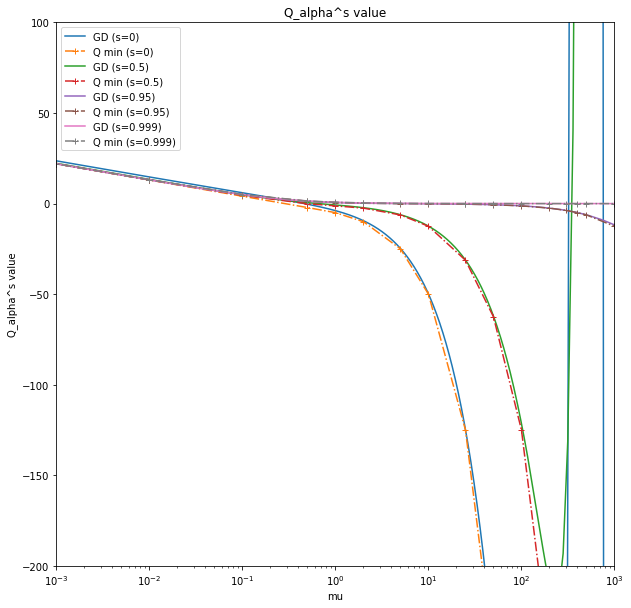

In [35]:
s_vals_to_draw = [0, 0.5, 0.95, 0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [mu_val for mu_val in res_Q['mu']],
        [Q_func(w, a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

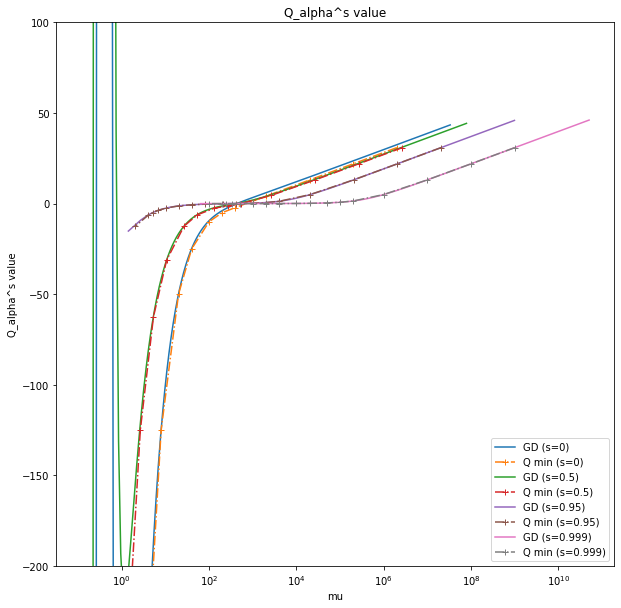

In [36]:
s_vals_to_draw = [0, 0.5, 0.95, 0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
        [Q_func(w , a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
#xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

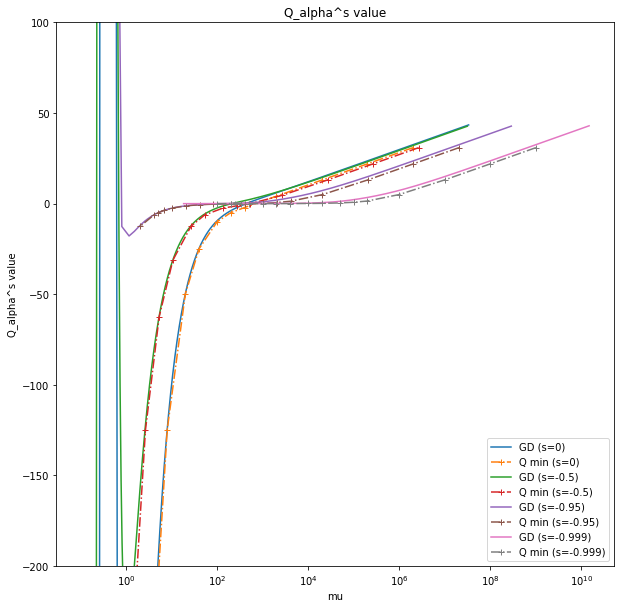

In [37]:
s_vals_to_draw = [0, -0.5, -0.95, -0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
        [Q_func(w, a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
#xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

### Plot NTK kerel change over time

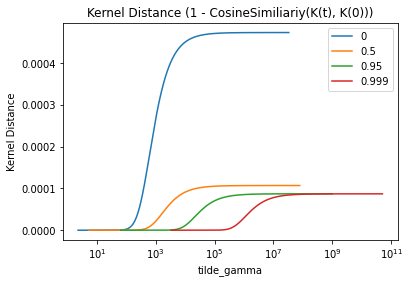

In [38]:
for k, res in results_GD.items():
    if k not in [0, 0.5, 0.95, 0.999]:
        continue

    kernel_distances_smooth = pd.Series(res['kernel_distances']).rolling(50).mean()
    plot([t for t in res['training_loss']], kernel_distances_smooth)

xscale('log')
ylabel('Kernel Distance')
xlabel('tilde_gamma');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');
legend([0, 0.5, 0.95, 0.999])

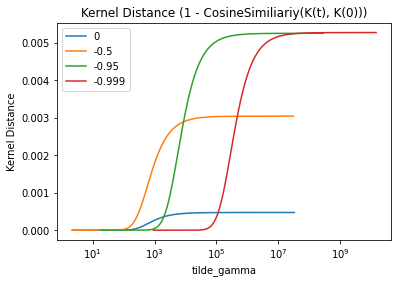

In [39]:
for k, res in results_GD.items():
    if k not in [0, -0.5, -0.95, -0.999]:
        continue

    kernel_distances_smooth = pd.Series(res['kernel_distances']).rolling(50).mean()
    plot([t for t in res['training_loss']], kernel_distances_smooth)

xscale('log')
ylabel('Kernel Distance')
xlabel('tilde_gamma');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');
legend([0, -0.5, -0.95, -0.999])

### Second Layer sign switches

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


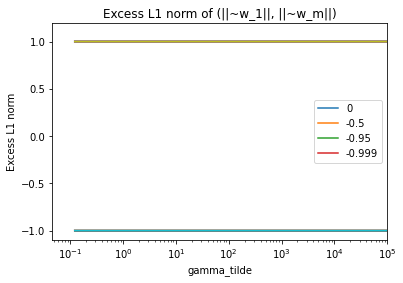

In [40]:
for k, res in results_GD.items():
    if k not in [0]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.sign(a.reshape(-1,)) for a in res['a']],
        '')

xscale('log')
xlim([0, 1e5])
ylim([-1.1, 1.2])
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, -0.5, -0.95, -0.999]);

##### Plot decision boundary over time

In [63]:
s_val = 0.999
res_GD = results_GD[s_val]

In [64]:
mu_vals = [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']]
print('mu range:' ,max(mu_vals), min(mu_vals))
print('gamma_tilde range:', min(res_GD['training_loss']), max(res_GD['training_loss']))

mu range: 1561.7965084334114 1.9797601643369514e-06
gamma_tilde range: 64.06085842314029 50536437097.17521


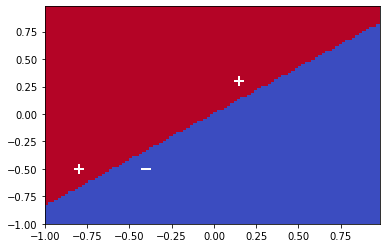

In [65]:
plot_classifier(res_GD['w'][-1], res_GD['a'][-1], x, y)

tilde_gamma=64.06085842314029, mu = 1561.7965084334114, min margin = 62.968787302152094


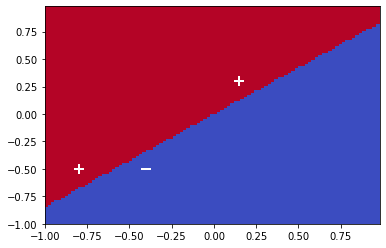

tilde_gamma=15732.775776333321, mu = 6.359337121108151, min margin = 15731.683675143157


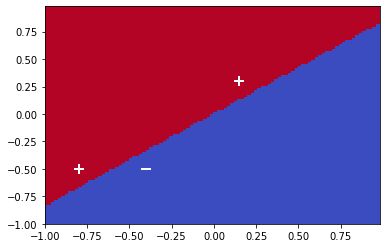

tilde_gamma=31459.672442805295, mu = 3.1802627695632175, min margin = 31458.58025261501


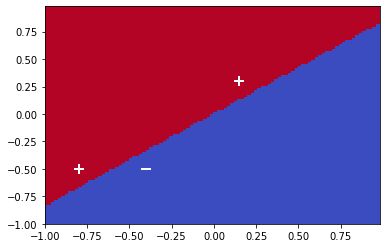

tilde_gamma=47302.91673976372, mu = 2.1150920896259167, min margin = 47301.82440377481


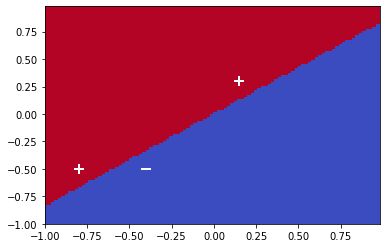

tilde_gamma=63321.10483579065, mu = 1.5800423140430875, min margin = 63320.01230066779


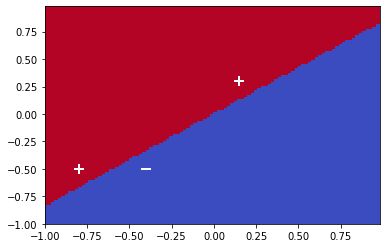

tilde_gamma=202405.14761239183, mu = 0.49430573378550896, min margin = 202404.0523415886


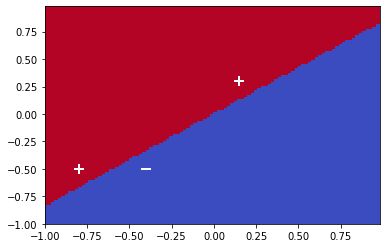

tilde_gamma=452658.59984095057, mu = 0.22102755818107048, min margin = 452657.5016747777


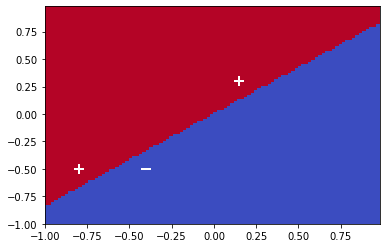

tilde_gamma=875494.2101159194, mu = 0.11427834000096988, min margin = 875493.1115045738


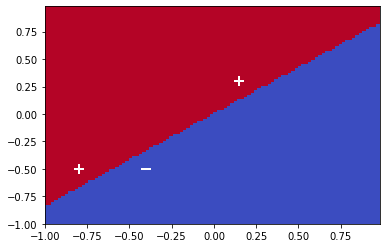

tilde_gamma=1632125.5099175414, mu = 0.06130044803819183, min margin = 1632124.4113052527


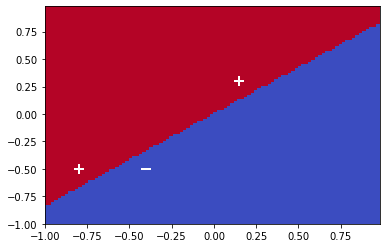

tilde_gamma=3011036.3456675075, mu = 0.033227770616740204, min margin = 3011035.247055219


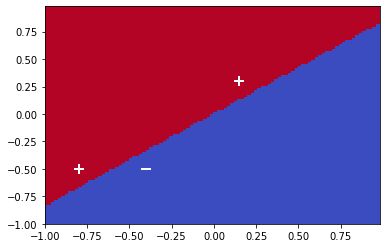

tilde_gamma=5537953.685241345, mu = 0.01806624444677843, min margin = 5537952.586629056


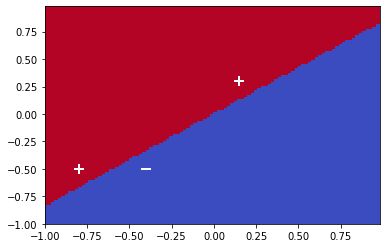

tilde_gamma=10176309.70964314, mu = 0.009831660775585428, min margin = 10176308.611030852


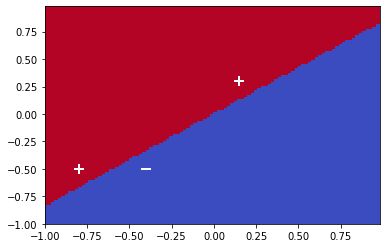

tilde_gamma=18694555.35899308, mu = 0.005351826940584505, min margin = 18694554.26038079


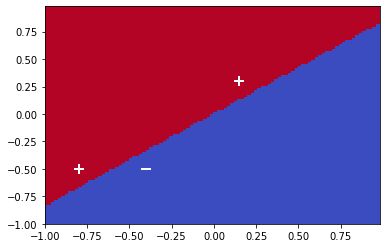

tilde_gamma=34340366.406129986, mu = 0.0029134815811006605, min margin = 34340365.3075177


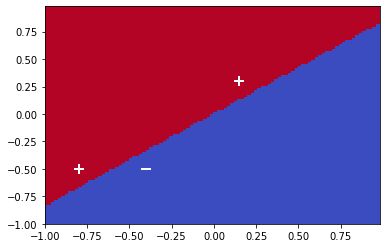

tilde_gamma=63079687.92013678, mu = 0.0015860894102579868, min margin = 63079686.82152449


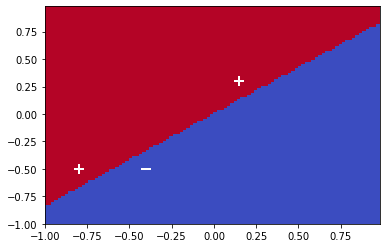

tilde_gamma=115868383.77864827, mu = 0.0008634799394771948, min margin = 115868382.68003598


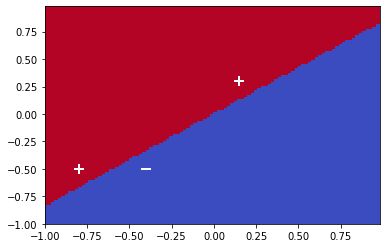

tilde_gamma=212832623.37139252, mu = 0.00047008782501318185, min margin = 212832622.27278024


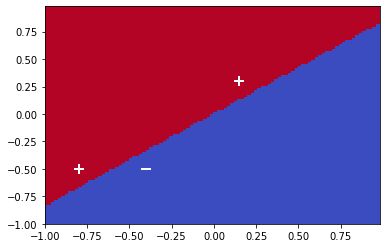

tilde_gamma=390944362.9535267, mu = 0.0002559188326866885, min margin = 390944361.85491437


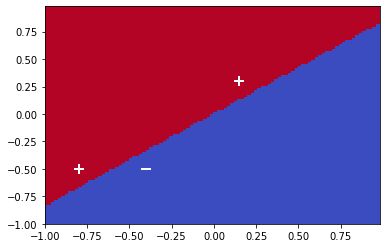

tilde_gamma=718113279.2539887, mu = 0.00013932345759772673, min margin = 718113278.1553764


KeyboardInterrupt: 

Process ForkPoolWorker-19:
Process ForkPoolWorker-23:
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-18:
Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shaharazulay/anaconda3/envs/cosmetics/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shaharazulay/anaconda3/envs/cosmetics/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shaharazulay/anaconda3/envs/cosmetics/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shaharazulay/anaconda3

In [66]:
num_plots = 25
idx = 0
for i in range(num_plots):
    print("tilde_gamma={}, mu = {}, min margin = {}".format(
        res_GD['training_loss'][idx],
        2 * alpha[0]/(1 - s_val**2)/res_GD['training_loss'][idx], 
        minimal_margin(res_GD['w'][idx], res_GD['a'][idx], x, y)))
    plot_classifier(res_GD['w'][idx], res_GD['a'][idx], x, y)
    idx += len(res_GD['training_loss']) // num_plots    

##### NTK solution

In [476]:
clf = fit_svm_with_tangent_kernel(res_GD['w_0'], res_GD['a_0'], x, y)

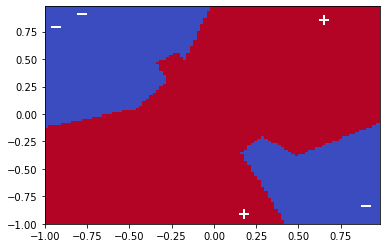

In [477]:
plot_svm_classifier(clf, x, y)

##### Show Q is a good predictor for L1 convergence

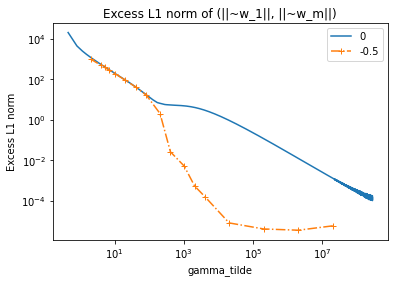

In [77]:
for s_val in [-0.95]:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]
    
    plot(
        [t for t in res_GD['training_loss']],
        [np.linalg.norm(calc_w_tilde_norms(w, a), ord=1) / minimal_margin(w, a, x, y) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for w, a in zip(res_GD['w'], res_GD['a'])],
        '')
    
    plot(
    [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
    [np.linalg.norm(calc_w_tilde_norms(w, a), ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1)
     for w, a in zip(res_Q['w'], res_Q['a'])],
    '-.+')


yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, -0.5, -0.95, -0.999]);

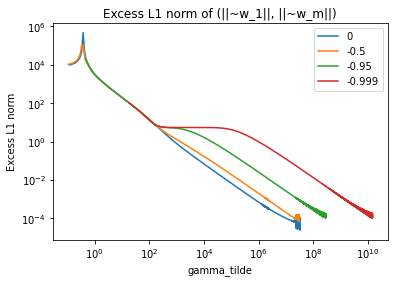

In [61]:
for k, res in results_GD.items():
    if k not in [0, -0.5, -0.95, -0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res['w_tilde_norms']],
        '')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, -0.5, -0.95, -0.999]);

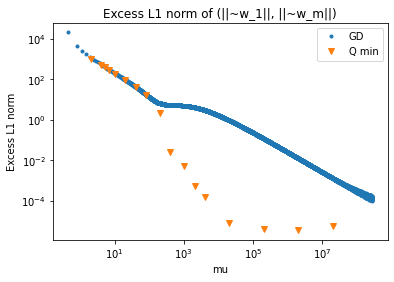

In [48]:
for s_val in [-0.95]:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]
    
    plot(
        [t for t in res_GD['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res_GD['w_tilde_norms']],
        '.')
    
    plot(
    [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
    [np.linalg.norm(calc_w_tilde_norms(w, a), ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) 
     for w, a in zip(res_Q['w'], res_Q['a'])],
    'v')

yscale('log')
xscale('log')
#xlim([1e-4, 1e3])
ylabel('Excess L1 norm')
xlabel('mu');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend(['GD', 'Q min', 'linear trend line']);

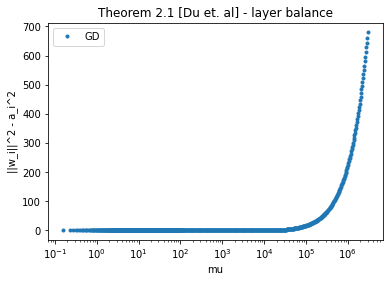

In [152]:
s_val = 0
res_GD = results_GD[s_val]
plot(
    [t for t in res_GD['training_loss']],
    [np.abs(np.mean(np.abs(a)**2 - np.linalg.norm(w, ord=2, axis=1)**2)) for w, a in zip(res_GD['w'], res_GD['a'])],
    '.')

xscale('log')
#yscale('log')
ylabel('||w_i||^2 - a_i^2')
xlabel('mu');
title(f'Theorem 2.1 [Du et. al] - layer balance');
legend(['GD']);

### Plot q_s

/Users/shaharazulay/Documents/work/relu-inductive-bias/source/Q_minimization.py:16: RuntimeWarning: divide by zero encountered in log
  return (x * np.log(x + np.sqrt(x**2 + s**2)) - np.sqrt(x**2 + s**2) + np.abs(s)) / 2
/Users/shaharazulay/Documents/work/relu-inductive-bias/source/Q_minimization.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return (x * np.log(x + np.sqrt(x**2 + s**2)) - np.sqrt(x**2 + s**2) + np.abs(s)) / 2


Text(0.5, 1.0, 'q_s')

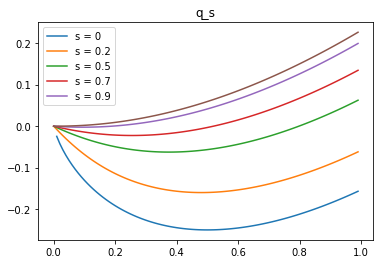

In [183]:
mu = 1
x = list(np.arange(0, mu, 0.01))
for s in [0, 0.2, 0.5, 0.7, 0.9, 0.99]:
    plot(x, list(map(lambda x: q_func(x/mu, s), x)))
    
legend([f's = {k}' for k in [0, 0.2, 0.5, 0.7, 0.9]])
title('q_s')